In [1]:
# set the working directory to be the root of the package
# so that the imports work below
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import models.data_util
import seaborn
import random

In [3]:
data_file = "../data/small.pkl"  # set this accordingly

db = pd.read_pickle(data_file)

# Load the lat/long for each company
x = db[['lat', 'long']].to_numpy()
y = db['isfailed'].to_numpy().reshape((-1,))

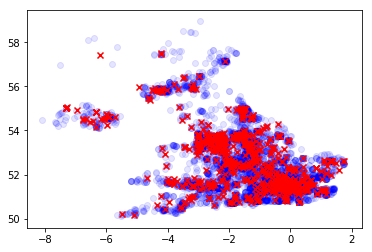

In [4]:
# plot the lat/long of all companies in the dataset:

failedcomps = np.nonzero(y == 1)
notfailedcomps = np.nonzero(y == 0)

# transpose is needed to make the UK look upright!
plt.scatter(x[notfailedcomps].T[1], x[notfailedcomps].T[0],
            marker='o', alpha=0.1, color='blue')
plt.scatter(x[failedcomps].T[1], x[failedcomps].T[0],
            marker='x', alpha=1.0, color='red')
plt.show()

In [5]:
# file path of a cleaned data file (so we can see the difference
# to lat/long)

cleaned_data_file = "../data/clean.pkl"  # set this accordingly

clean_data = pd.read_pickle(cleaned_data_file)

In [6]:
clean_db_failed = clean_data[clean_data['isfailed'] == 1]
clean_db_notfailed = clean_data[clean_data['isfailed'] == 0]

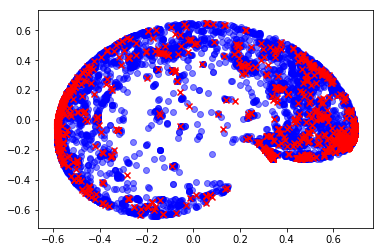

In [7]:
# plot the lat/long of the companies in the cleaned dataset, which has had
# PCA applied to the positions:

plt.scatter(clean_db_notfailed['pos1'].to_numpy(), clean_db_notfailed['pos2'].to_numpy(),
            marker='o', alpha=0.5, color='blue')
plt.scatter(clean_db_failed['pos1'].to_numpy(), clean_db_failed['pos2'].to_numpy(),
            marker='x', alpha=1.0, color='red')
plt.show()

In [8]:
# Now let's examine the following accounting fields:
# Field2267, Field2816, Field972, Field477, Field2823
# These are pesky because they don't have a corresponding hasFN field
# and some of the fields contain strings, too.
from models.feature_util import (accounting_field_nums,
                                 bad_accounting_field_nums)

In [9]:
# As we can see from this, most of these fields are pretty hard to train on:
for n in bad_accounting_field_nums:
    fieldName = 'Field' + str(n)
    fieldNotNone = db[db[fieldName].notna()][fieldName]
    series = fieldNotNone.sample(frac=0.1).to_numpy()
    print(fieldName, ':', series.shape)
    print(series)

Field2267 : (219,)
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '']
Field2816 : (11,)
['Turnover represents net invoiced sales of goods, excluding value added tax. '
 'Turnover represents amounts receivable for services provided.'
 'Turnover represents net invoiced sales of goods, excluding value added tax.'
 'Turnover comprises revenue recognised by the company in respect of go

Field1014 : 9678 values


e:\programs folder\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
e:\programs folder\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


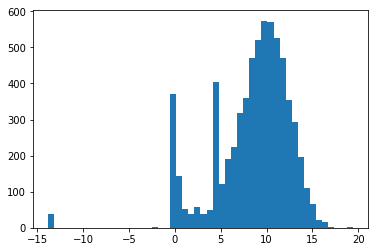

Field1129 : 10687 values


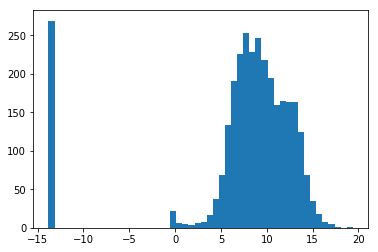

Field1522 : 11180 values


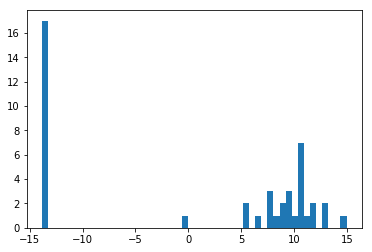

Field1631 : 11094 values


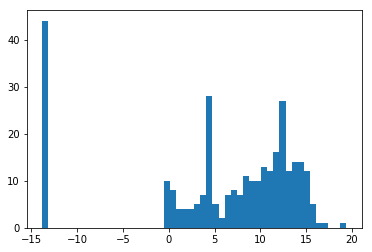

Field17 : 11171 values


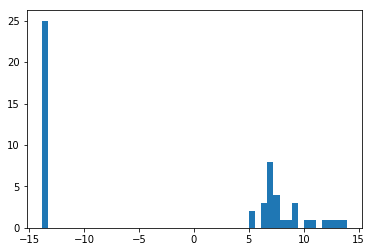

Field1865 : 10025 values


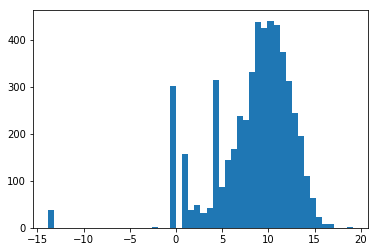

Field1871 : 10951 values


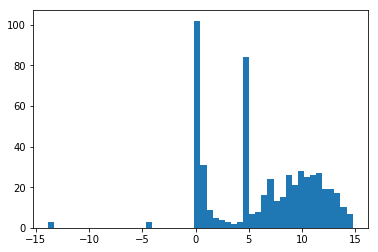

Field1885 : 10488 values


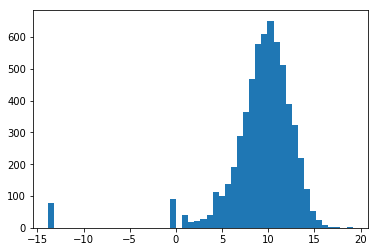

Field1977 : 11196 values


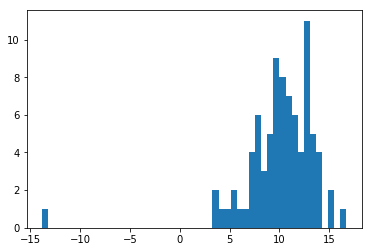

Field2298 : 11195 values


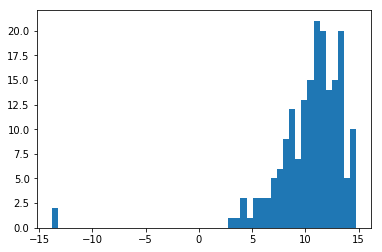

Field2304 : 11195 values


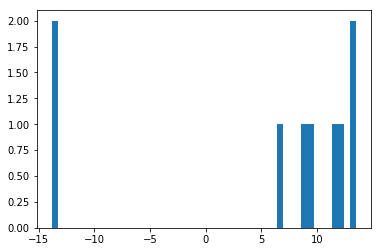

Field2316 : 10973 values


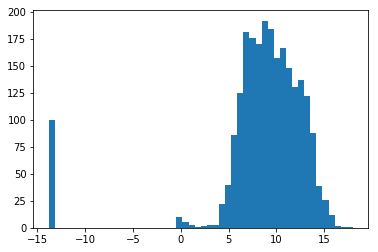

Field2447 : 11184 values


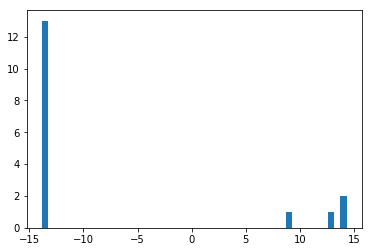

Field2483 : 11196 values


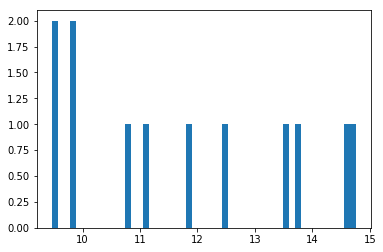

Field2497 : 10927 values


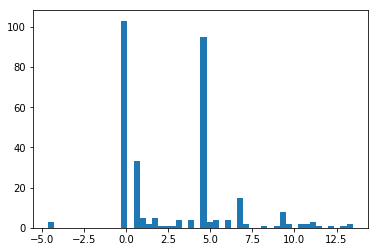

Field2502 : 10956 values


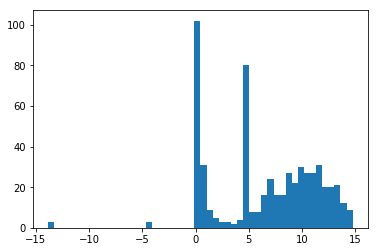

Field2815 : 11196 values


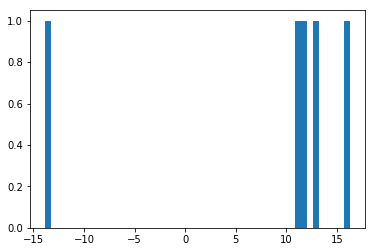

Field282 : 11192 values


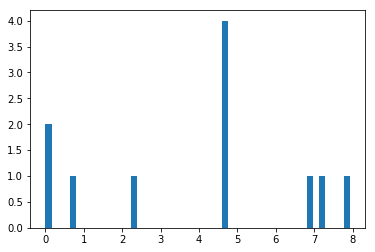

Field306 : 10588 values


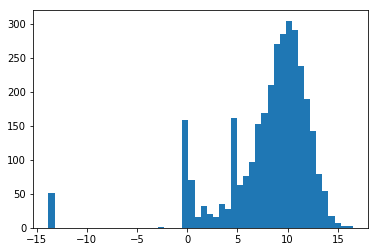

Field448 : 11194 values


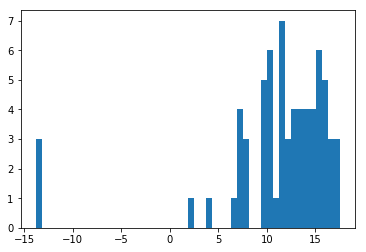

Field465 : 10880 values


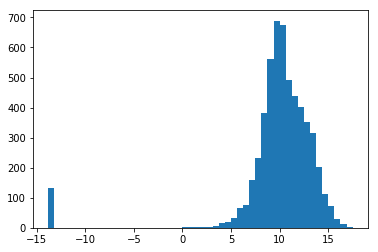

Field474 : 11178 values


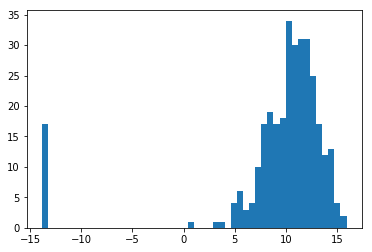

Field487 : 11160 values


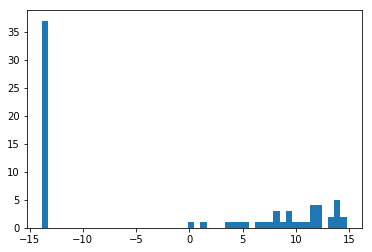

Field489 : 10757 values


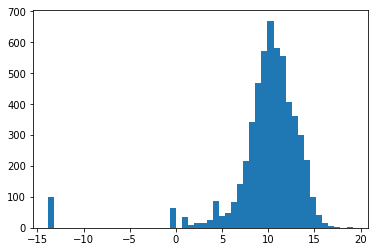

Field541 : 10919 values


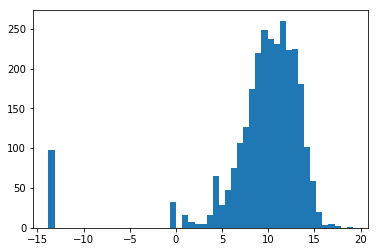

Field69 : 11185 values


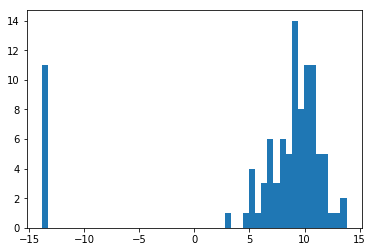

Field70 : 11183 values


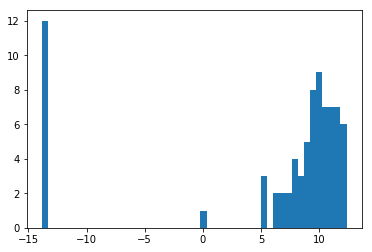

In [10]:
# Now examine the "good" accounting fields:
acc_field_names = ['Field' + str(n) for n in accounting_field_nums]
for field_name in acc_field_names:
    col_data = db[field_name].to_numpy()
    print(field_name, ':', len(np.unique(col_data)), 'values')
    col_data = np.log(col_data + 1.0e-6)  # plot on log scale
    plt.hist(col_data, bins=50)
    plt.show()

In [13]:
print("Columns in cleaned dataset:")
for col in clean_data.columns:
    # get num unique values of this col:
    numunique = -1
    
    try:
        numunique = len(np.unique(clean_data[col]))
    except TypeError:
        pass  # can occur when comparing None values
    
    print(col, ':', numunique, "unique value(s)")

Columns in cleaned dataset:
Field1014 : 9678 unique value(s)
Field1129 : 10687 unique value(s)
Field1522 : 11180 unique value(s)
Field1631 : 11094 unique value(s)
Field17 : 11171 unique value(s)
Field1865 : 10025 unique value(s)
Field1871 : 10951 unique value(s)
Field1885 : 10488 unique value(s)
Field1977 : 11196 unique value(s)
Field2298 : 11195 unique value(s)
Field2304 : 11195 unique value(s)
Field2316 : 10973 unique value(s)
Field2447 : 11184 unique value(s)
Field2483 : 11196 unique value(s)
Field2497 : 10927 unique value(s)
Field2502 : 10956 unique value(s)
Field2506 : 11189 unique value(s)
Field2616 : 11189 unique value(s)
Field2619 : 11195 unique value(s)
Field2705 : 10519 unique value(s)
Field2815 : 11196 unique value(s)
Field282 : 11192 unique value(s)
Field306 : 10588 unique value(s)
Field448 : 11194 unique value(s)
Field465 : 10880 unique value(s)
Field474 : 11178 unique value(s)
Field487 : 11160 unique value(s)
Field489 : 10757 unique value(s)
Field541 : 10919 unique value(